# Preprocessing(2) & Analysis 

## Importing Necessary Libraries

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

import re
import joblib
from sklearn.model_selection import train_test_split
import ast
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading Data 

In [150]:
df = pd.read_csv('preprocessed_game_info.csv')

In [151]:
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            print(f"Conversion failed for column: {column}")

Conversion failed for column: NAME
Conversion failed for column: DEVELOPERS


In [152]:
technologies = [col for col in df.columns if col.startswith('TECH')]
genres = [col for col in df.columns if col.startswith('GENRE')]
platforms = [col for col in df.columns if col.startswith('OS')]

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(exclude=['object']).columns.tolist()

categorical_features = [col for col in categorical_features if col not in technologies + genres + platforms]
numerical_features = [col for col in numerical_features if col not in technologies + genres + platforms]

label_encoders = {}
for column in ['NAME', 'DEVELOPERS']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
# print("Technologies:", technologies)
# print("Genres:", genres)
# print("Platforms:", platforms)
# print("Categorical Features:", categorical_features)
# print("Numerical Features:", numerical_features)

## Initial Data Exploration

In [153]:
df.head()

,NAME,N_SUPPORTED_LANGUAGES,DEVELOPERS,POSITIVE_REVIEWS,NEGATIVE_REVIEWS,PRICE,24_HOUR_PEAK,PUBLISH_YEAR,RATING_SCORE,TOTAL_RATE_SUM,...,GENRE: Massively Multiplayer,GENRE: RPG,GENRE: Racing,GENRE: Simulation,GENRE: Sports,GENRE: Store Genres,GENRE: Strategy,OS: Linux,OS: Windows,OS: macOS
0,470,7,205,39271,5015,NaN,1064.0,2016,0.886759,44286,...,0,1,0,0,0,0,0,0,1,0
1,614,24,999,156683,21075,NaN,16131.0,2021,0.881440,177758,...,0,0,1,1,1,0,0,0,1,0
2,1729,1,1067,872,70,4.99,21.0,2021,0.925690,942,...,0,0,0,1,0,0,0,1,1,0
3,894,12,149,22766,2819,NaN,31.0,2016,0.889818,25585,...,0,0,0,0,0,0,0,1,1,1
4,1587,1,1528,834,66,NaN,318.0,2023,0.926667,900,...,0,0,0,0,0,0,0,0,1,0


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Columns: 166 entries, NAME to OS: macOS
dtypes: float64(4), int32(2), int64(160)
memory usage: 2.6 MB


## Plot the Count of Unique Values for Each Feature 

In [155]:
unique_counts_categorical = df[categorical_features].nunique()
unique_counts_numerical = df[numerical_features].nunique()

tech_count = len(technologies)
genre_count = len(genres)
platform_count = len(platforms)

counts = pd.concat([unique_counts_categorical, unique_counts_numerical])
counts['Technologies'] = tech_count
counts['Genres'] = genre_count
counts['Platforms'] = platform_count

feature_colors = sns.color_palette('hls', n_colors=len(categorical_features) + len(numerical_features) + 3)
features = counts.index.tolist()
feature_color_map = dict(zip(features, feature_colors))
feature_color_map
colors = [feature_color_map[feature] for feature in features]


In [156]:
features

['NAME',
 'DEVELOPERS',
 'N_SUPPORTED_LANGUAGES',
 'POSITIVE_REVIEWS',
 'NEGATIVE_REVIEWS',
 'PRICE',
 '24_HOUR_PEAK',
 'PUBLISH_YEAR',
 'RATING_SCORE',
 'TOTAL_RATE_SUM',
 'TWITCH_PEAK_HOUR',
 'TWITCH_PEAK_YEAR',
 'Technologies',
 'Genres',
 'Platforms']

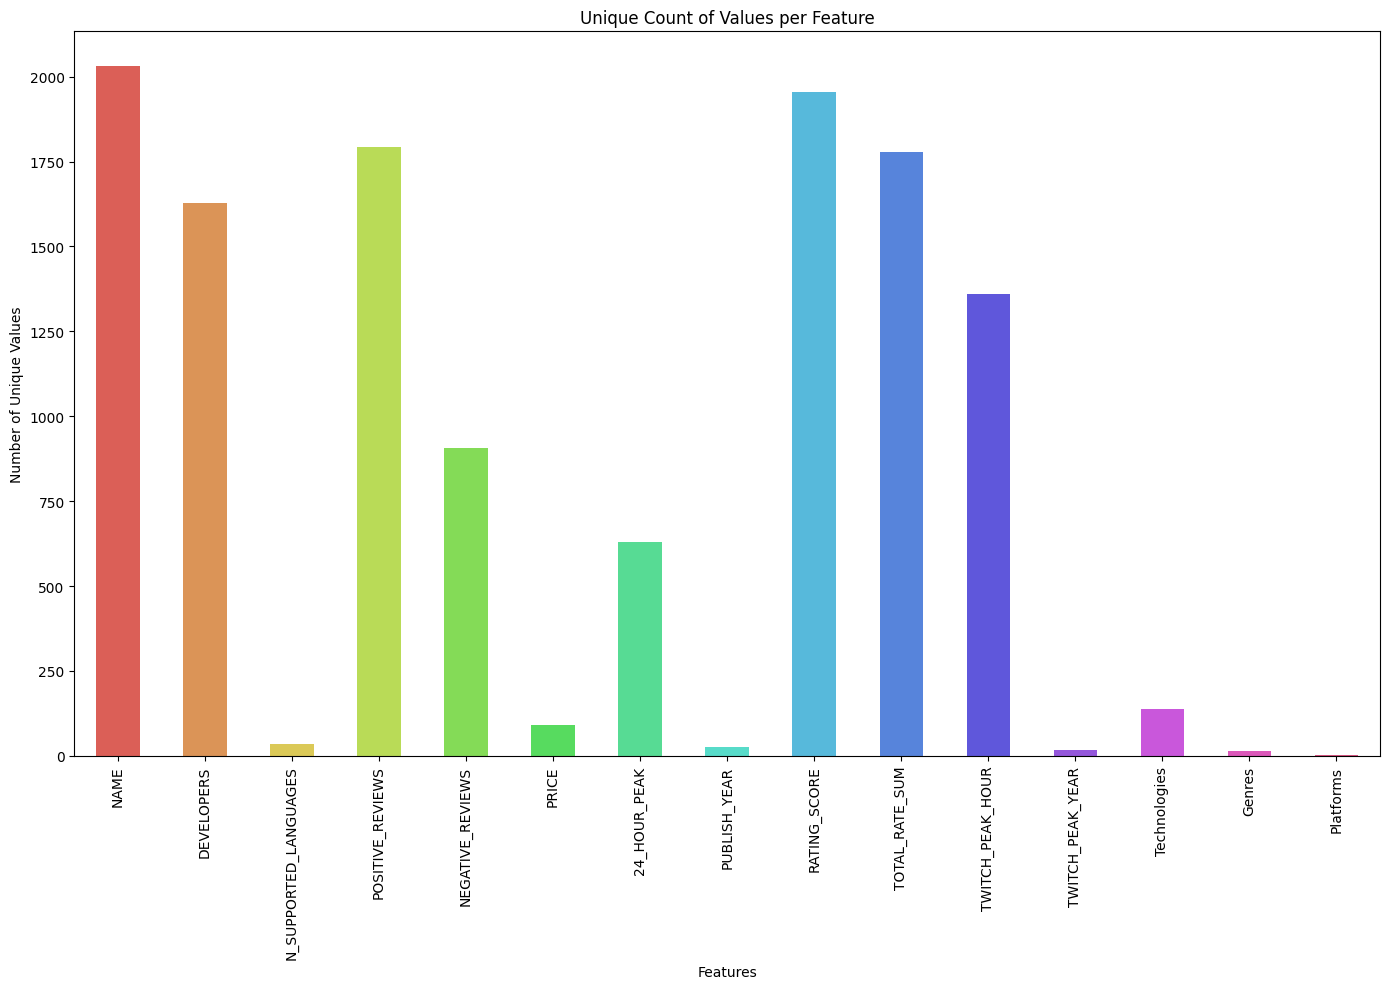

In [157]:
plt.figure(figsize=(14, 10))
counts.plot(kind='bar', color=colors)
plt.title('Unique Count of Values per Feature')
plt.xlabel('Features')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Outlier Detection and Handling

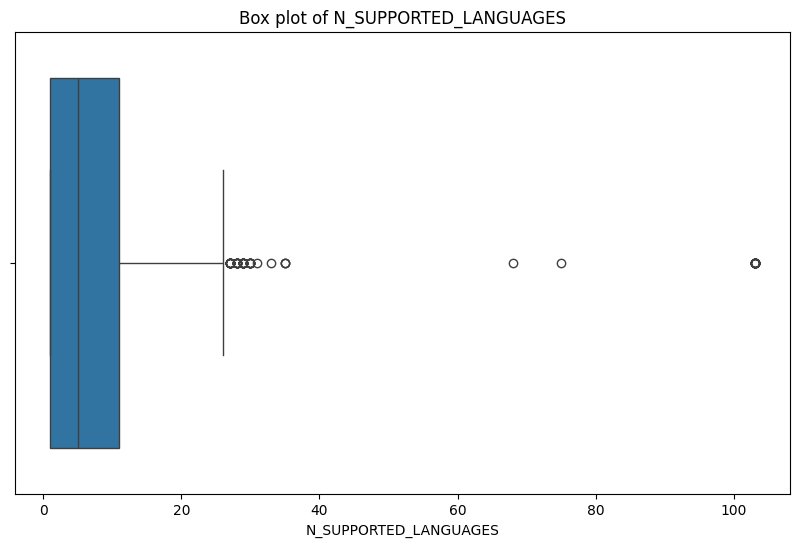

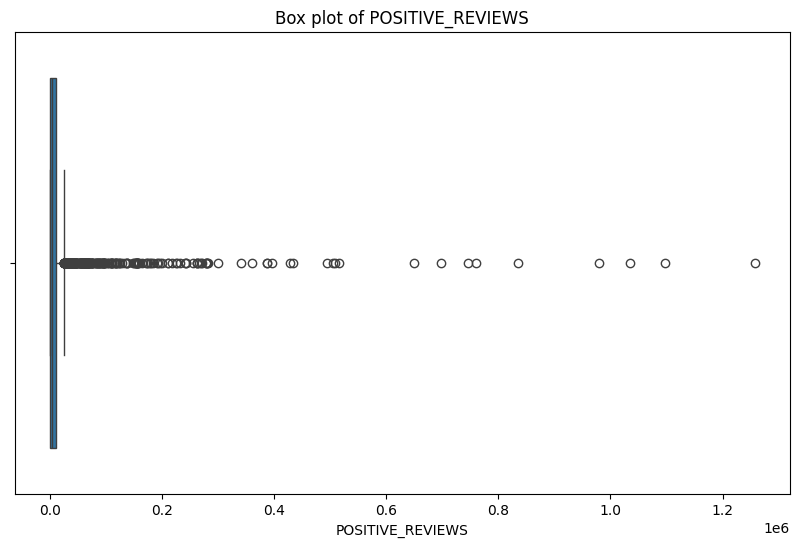

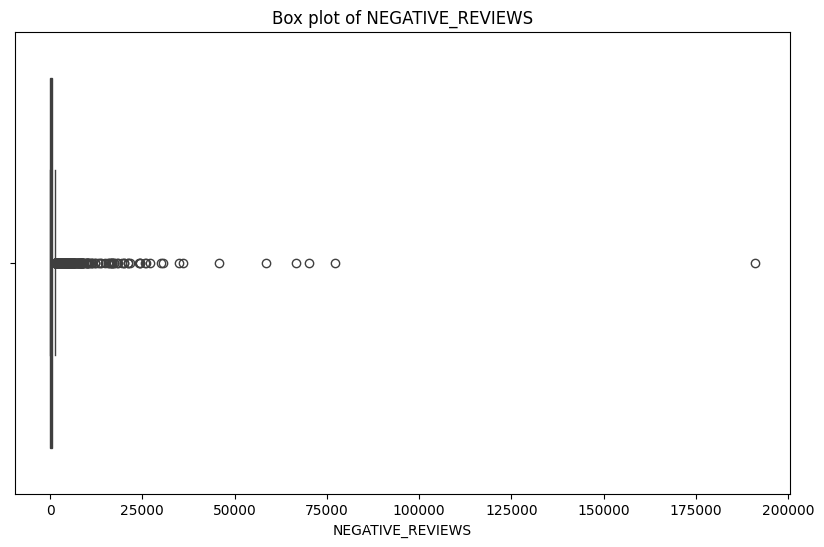

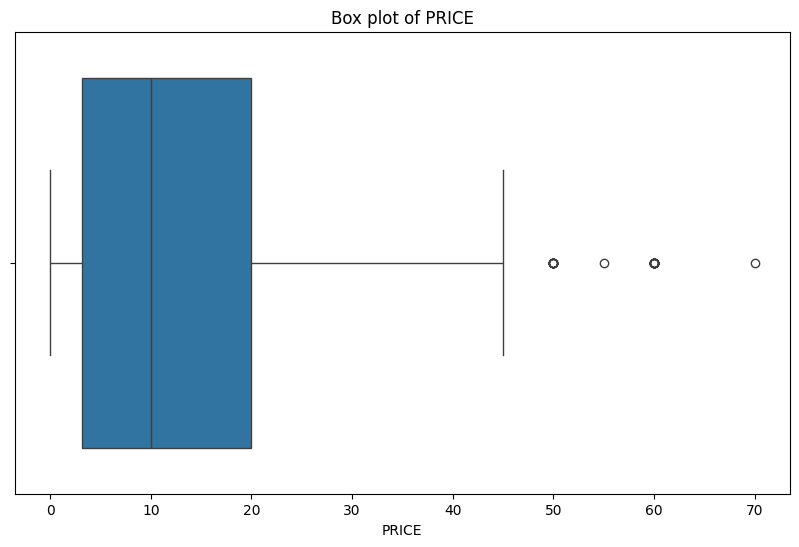

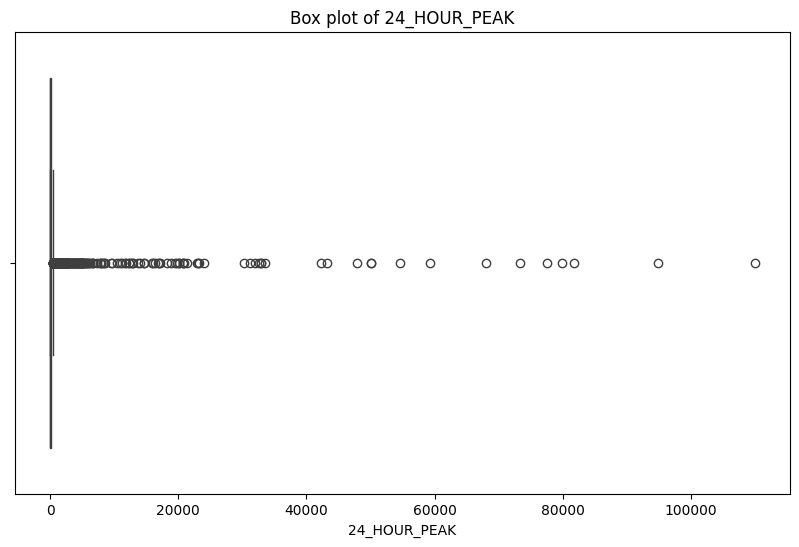

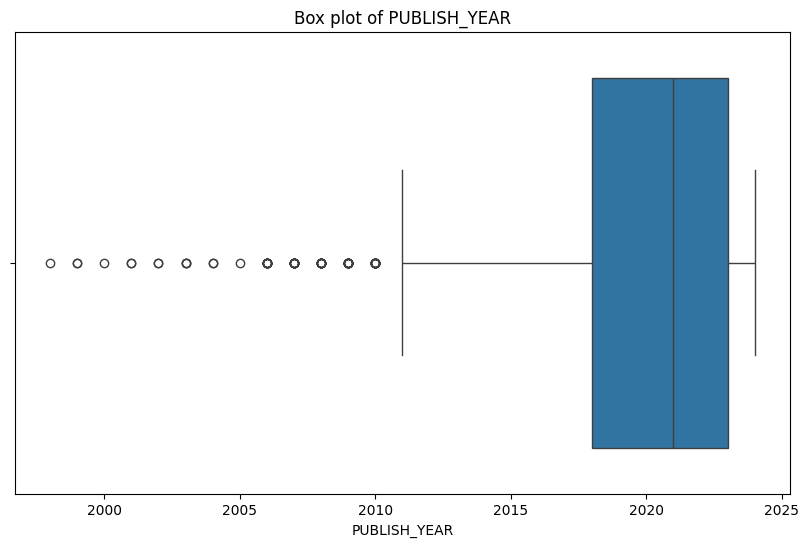

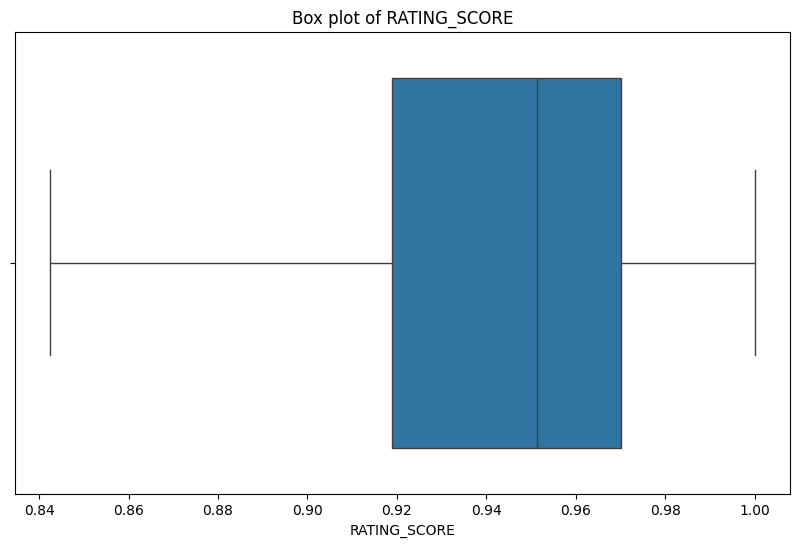

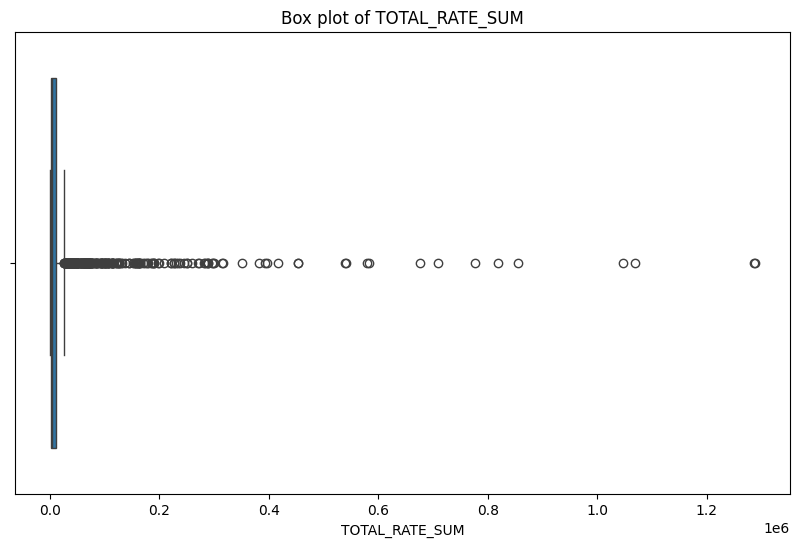

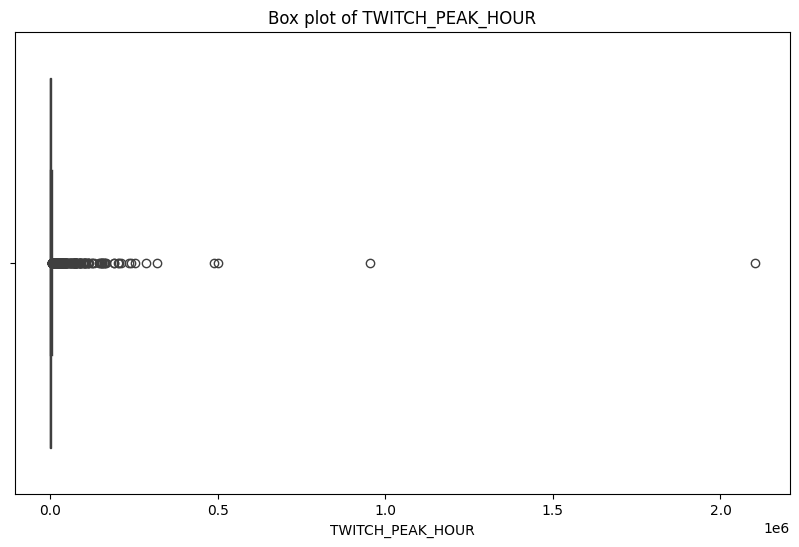

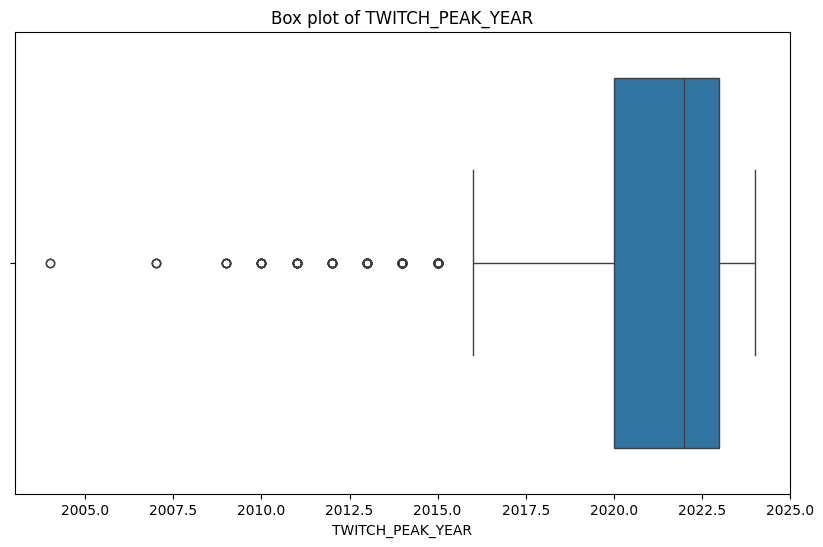

In [158]:
methods = {}

for column in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()

    mean = df[column].mean()
    median = df[column].median()
    std = df[column].std()
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    
    if len(outliers) / len(df) < 0.05:
        if abs(mean - median) / std > 0.5:
            methods[column] = 'transform'
        else:
            methods[column] = 'remove'
    else:
        methods[column] = 'cap'

In [159]:
methods

{'N_SUPPORTED_LANGUAGES': 'remove',
 'POSITIVE_REVIEWS': 'cap',
 'NEGATIVE_REVIEWS': 'cap',
 'PRICE': 'remove',
 '24_HOUR_PEAK': 'cap',
 'PUBLISH_YEAR': 'remove',
 'RATING_SCORE': 'remove',
 'TOTAL_RATE_SUM': 'cap',
 'TWITCH_PEAK_HOUR': 'cap',
 'TWITCH_PEAK_YEAR': 'cap'}

**Outlier Handling Suggestions:**
- Transform: Suggested if there is a significant skew in the data (mean and median are far apart relative to the standard deviation).
- Remove: Suggested if the number of outliers is low and the data distribution is not heavily skewed.
- Cap: Suggested if the number of outliers is high, indicating that simply removing them might lead to loss of significant data.

In [160]:
# def handle_outliers(df, methods, exclude_columns=[]):

#     df_cleaned = df.copy()  
    
#     for column, method in methods.items():
#         if column in exclude_columns:
#             continue
        
#         Q1 = df_cleaned[column].quantile(0.25)
#         Q3 = df_cleaned[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         if method == 'remove':
#             df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
#         elif method == 'cap':
#             df_cleaned[column] = df_cleaned[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
#         elif method == 'transform':
#             df_cleaned[column] = np.log1p(df_cleaned[column])  
#         else:
#             raise ValueError("Method must be either 'remove', 'cap', or 'transform'")
    
#     return df_cleaned

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Columns: 166 entries, NAME to OS: macOS
dtypes: float64(4), int32(2), int64(160)
memory usage: 2.6 MB


## Normalization/Standardization

## Split the dataset into training and testing sets


In [162]:
# X = df.drop(columns=['24_HOUR_PEAK'])
# y = df['24_HOUR_PEAK']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
# del df
# df = pd.concat([X_train, y_train], axis=1)
# df.info()

# Feature Engineering and Selection (Analysis) 

In [164]:
target_column = '24_HOUR_PEAK'


## Correlation Heatmap

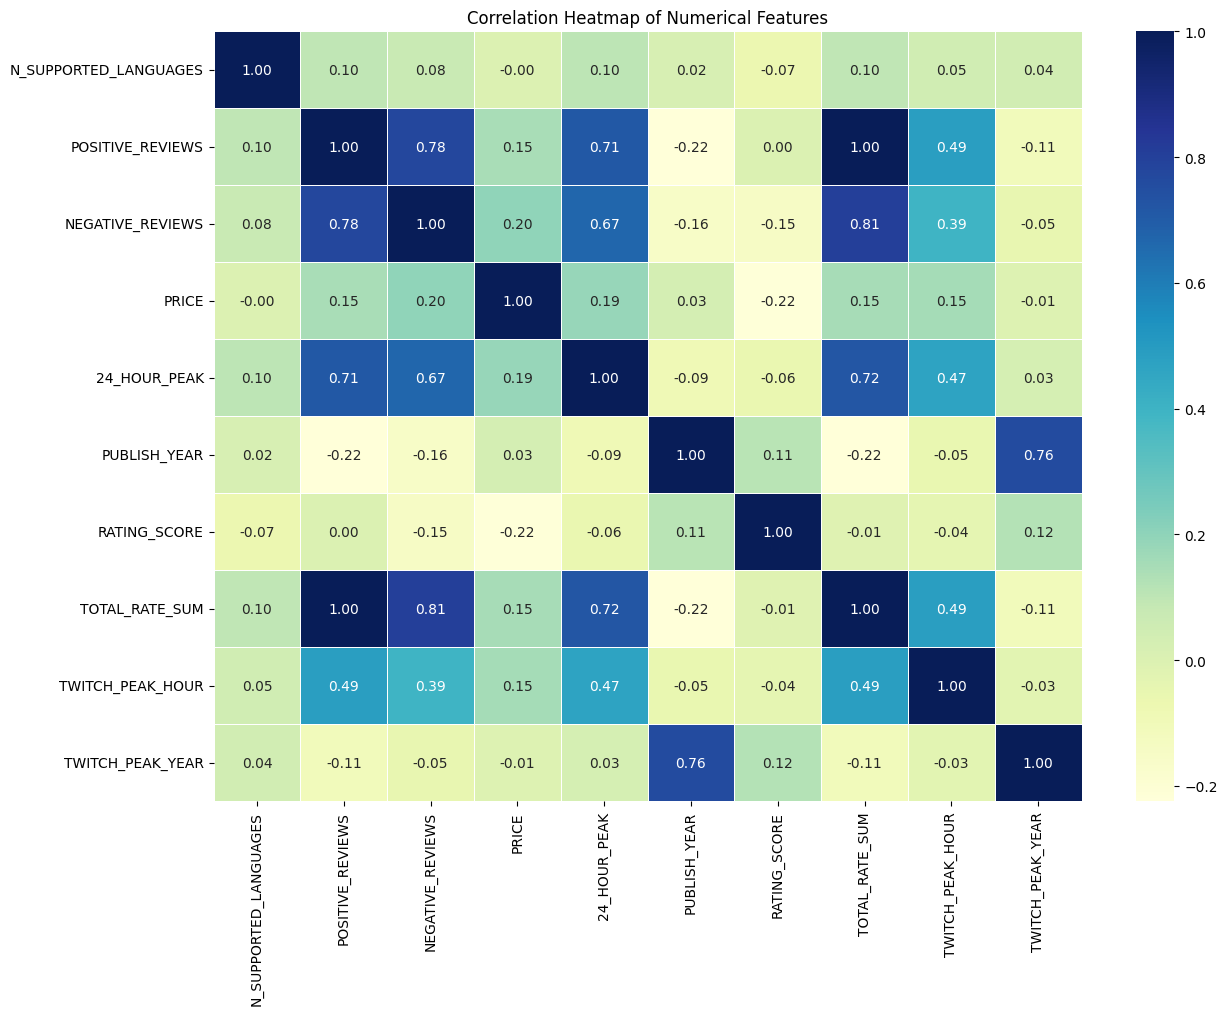

In [165]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [166]:
correlations_with_target = df[numerical_features + [target_column]].corr()[target_column].drop(target_column)

print("Correlation of numerical features with the target variable '24_HOUR_PEAK':")
print(correlations_with_target)


Correlation of numerical features with the target variable '24_HOUR_PEAK':
                       24_HOUR_PEAK  24_HOUR_PEAK
N_SUPPORTED_LANGUAGES      0.102634      0.102634
POSITIVE_REVIEWS           0.713983      0.713983
NEGATIVE_REVIEWS           0.667456      0.667456
PRICE                      0.185387      0.185387
PUBLISH_YEAR              -0.087232     -0.087232
RATING_SCORE              -0.059560     -0.059560
TOTAL_RATE_SUM             0.721471      0.721471
TWITCH_PEAK_HOUR           0.465874      0.465874
TWITCH_PEAK_YEAR           0.027272      0.027272


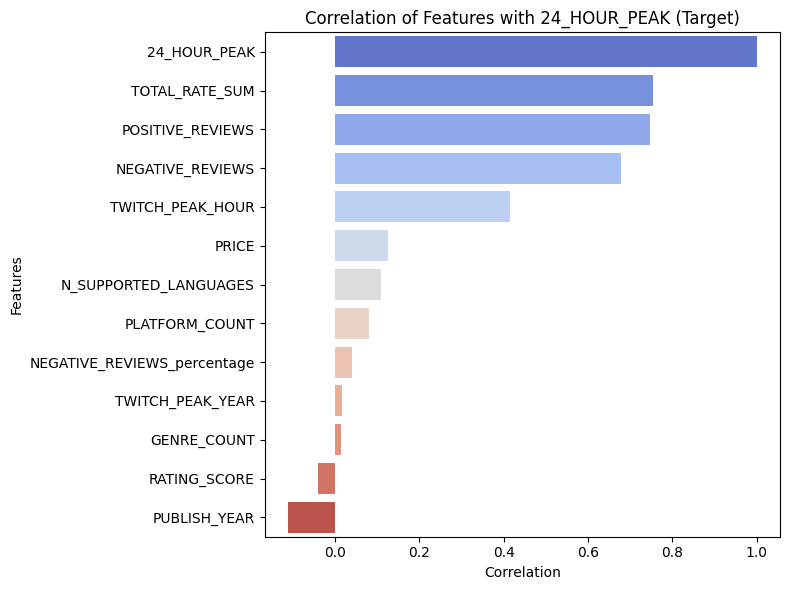

In [167]:
plt.figure(figsize=(8, 6))
sns.barplot(y=target_corr.index, x=target_corr, palette='coolwarm', orient='h')
plt.title('Correlation of Features with 24_HOUR_PEAK (Target)')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()


## Histograms

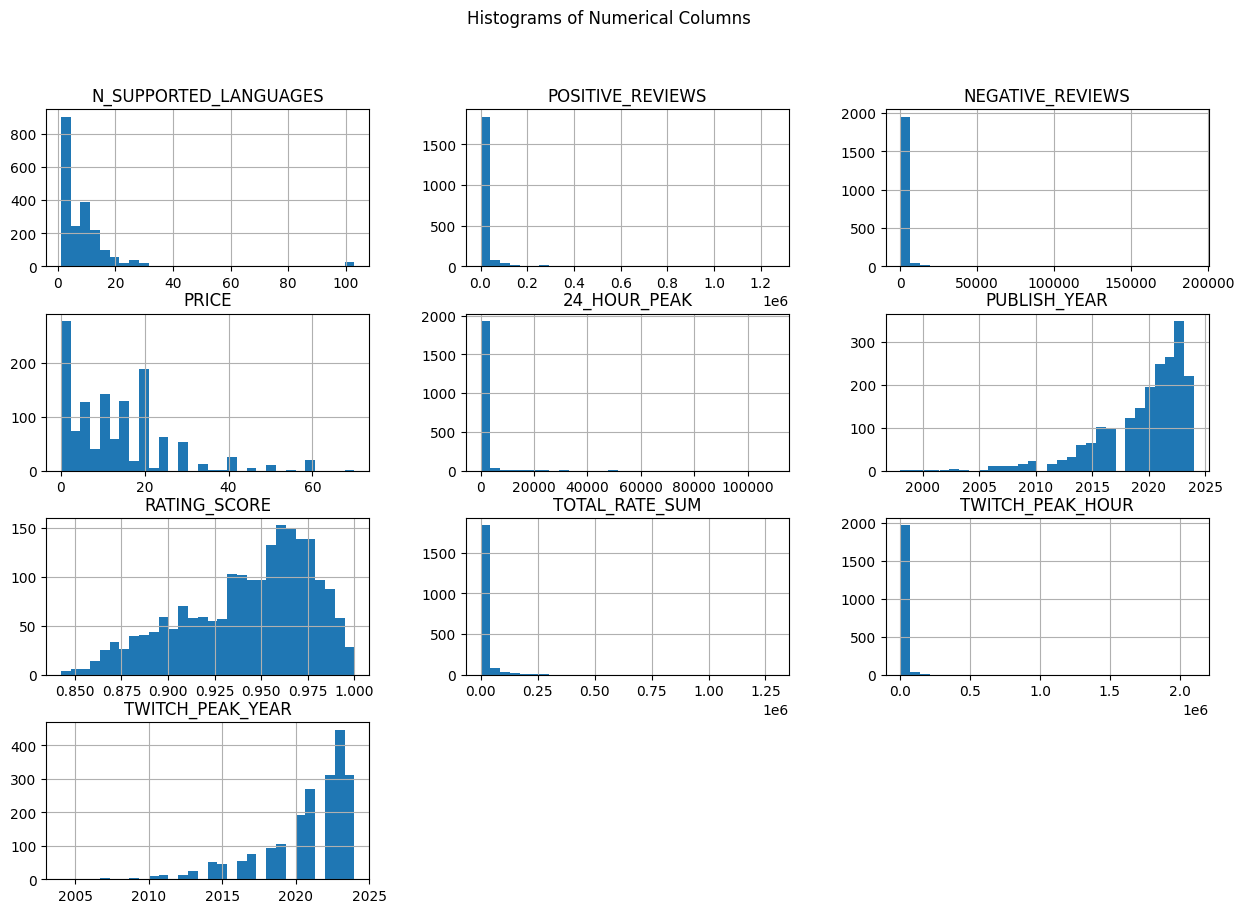

In [168]:
df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Columns")
plt.show()

##  Plot pair plot

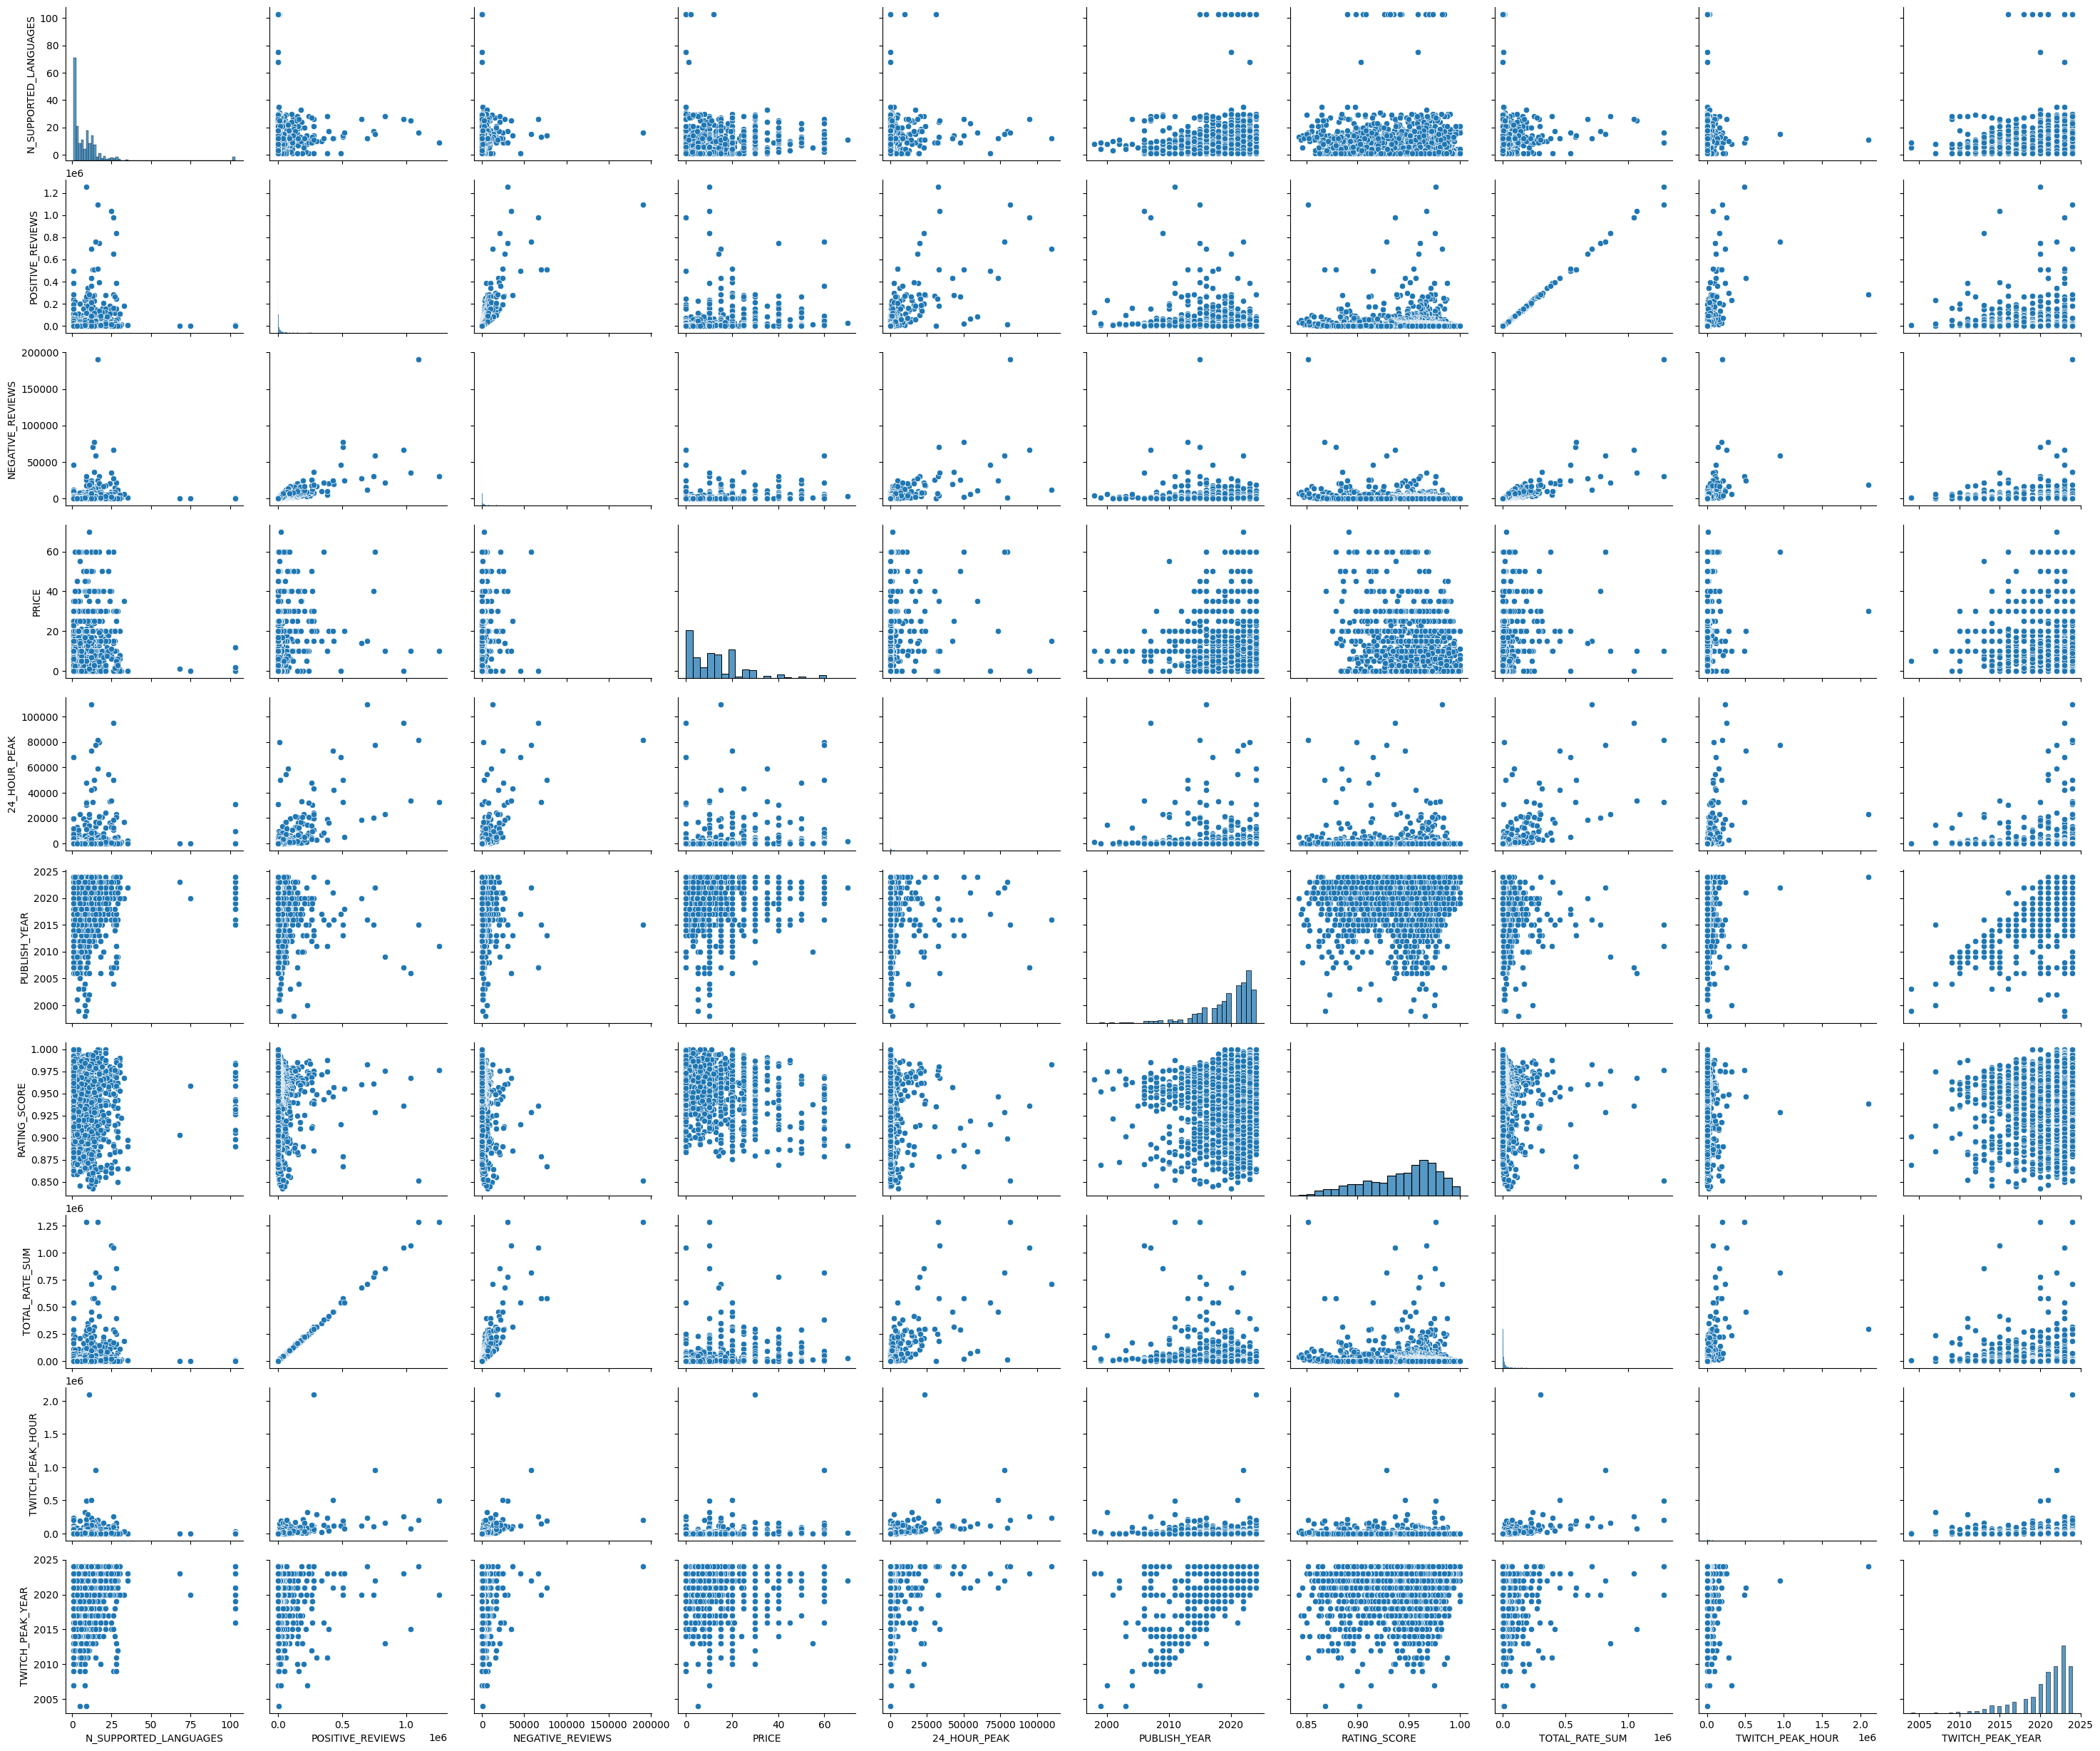

In [169]:
sns.pairplot(df[numerical_features], height=2.5, aspect=1.2)
plt.show()

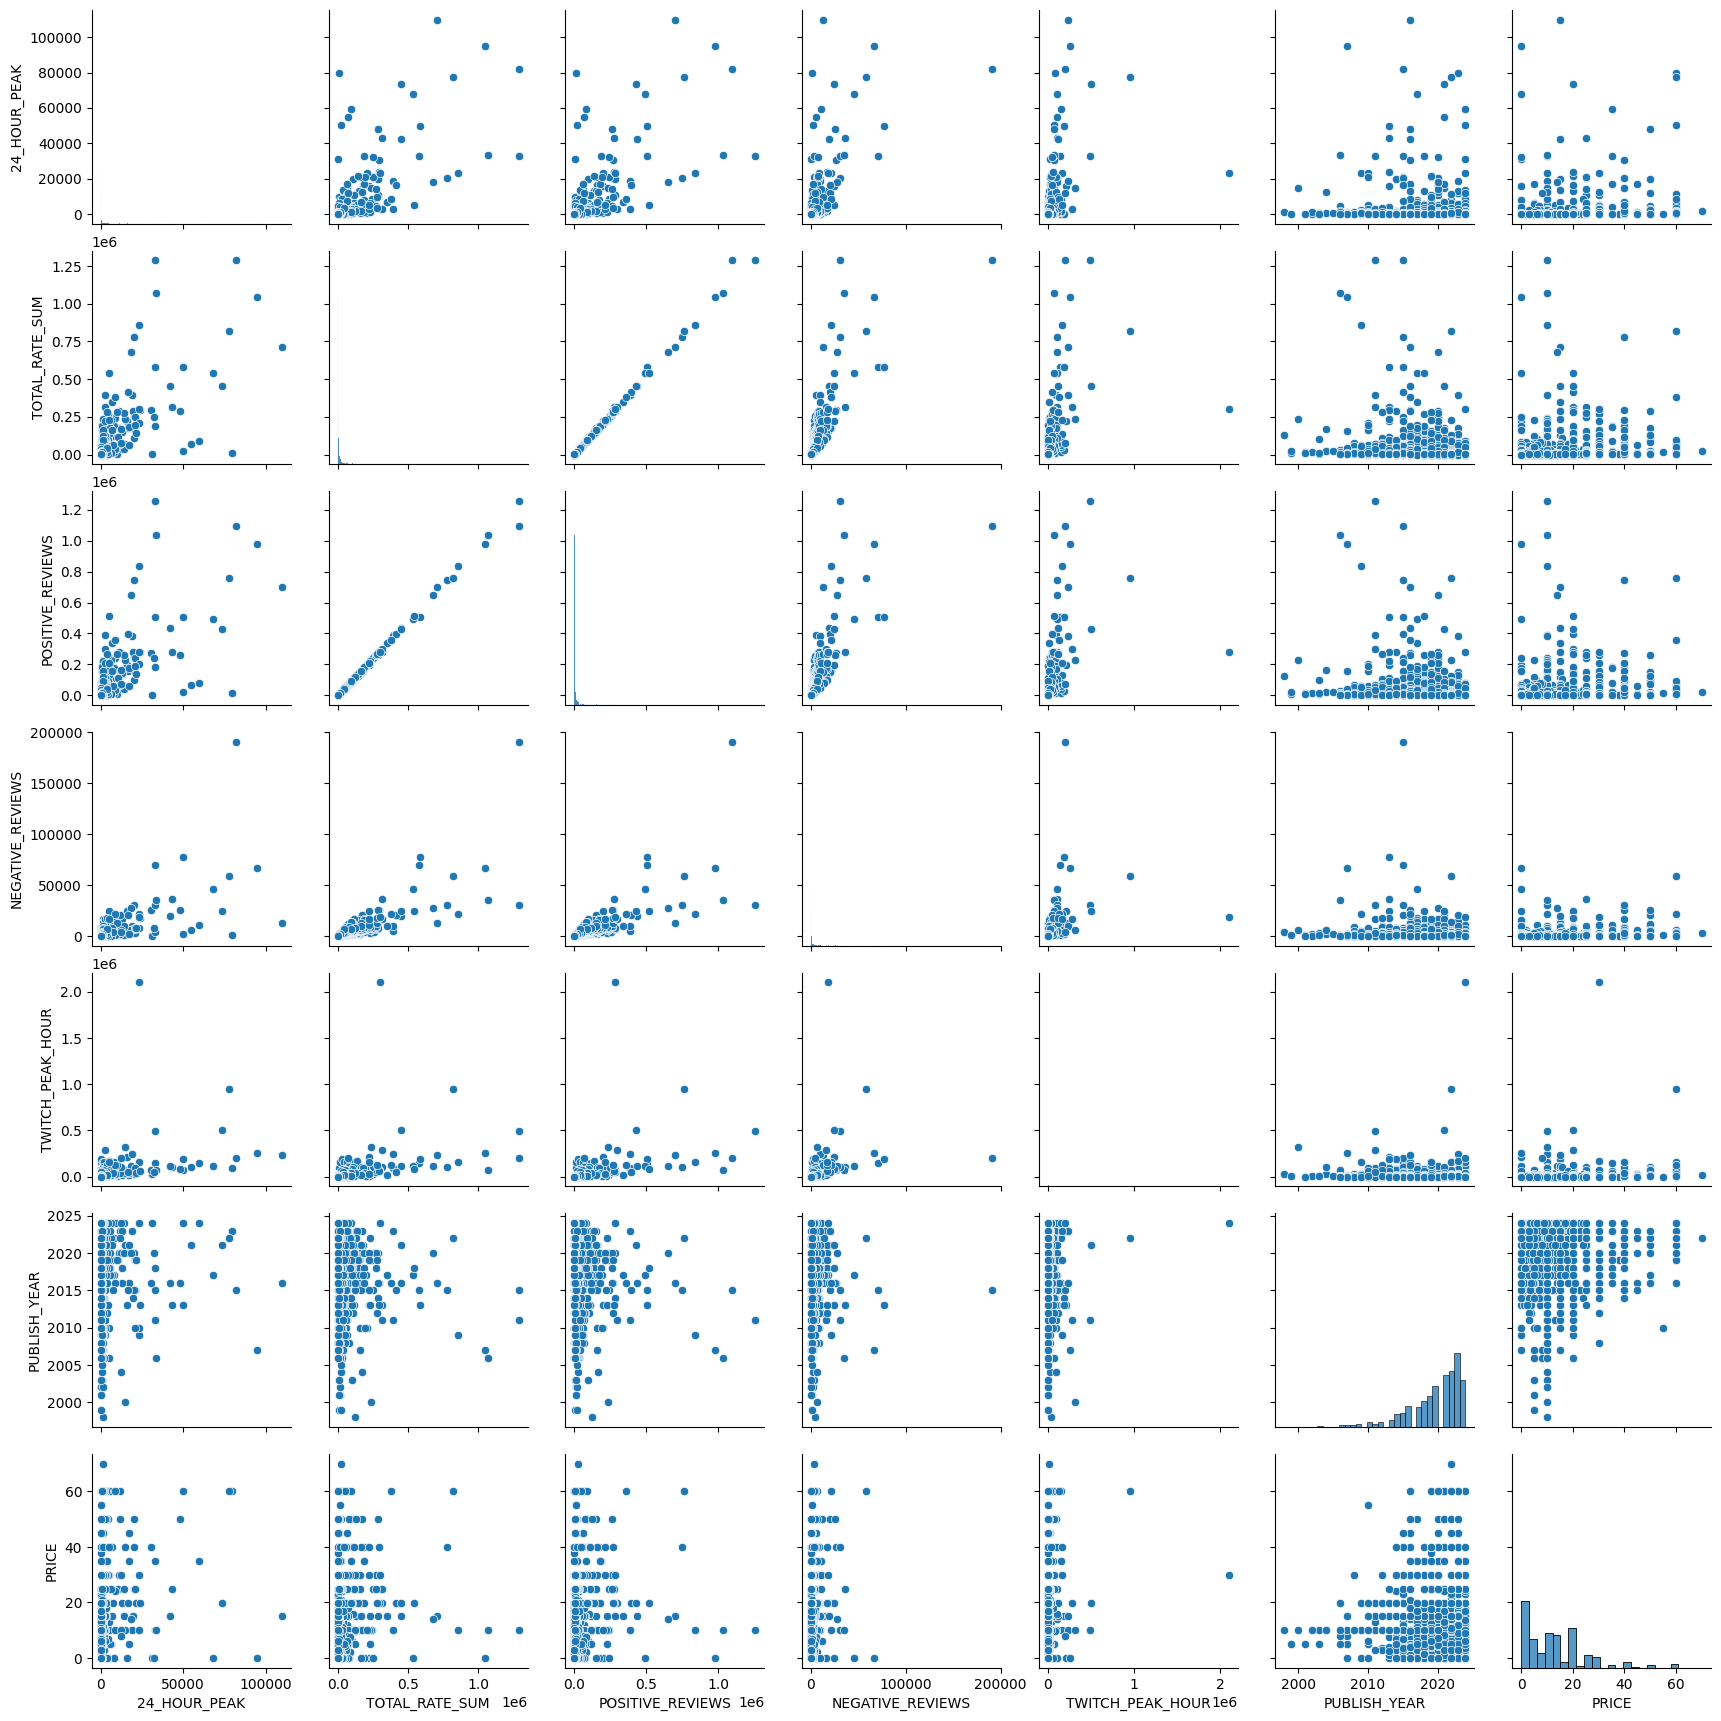

In [170]:
selected_features = ['24_HOUR_PEAK', 'TOTAL_RATE_SUM', 'POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'TWITCH_PEAK_HOUR', 'PUBLISH_YEAR', 'PRICE']

sns.pairplot(df[selected_features])
plt.show()

## Summary statistics for the `24_HOUR_PEAK` column

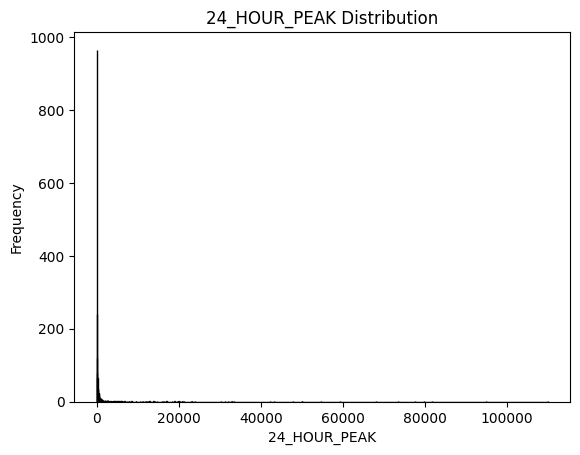

In [171]:
plt.hist(df['24_HOUR_PEAK'], bins='auto', color=feature_color_map['24_HOUR_PEAK'], edgecolor='black')
plt.xlabel('24_HOUR_PEAK')
plt.ylabel('Frequency')
plt.title('24_HOUR_PEAK Distribution')
plt.show()

In [172]:
df['24_HOUR_PEAK'].describe()

count      2032.000000
mean       1185.736713
std        6441.760299
min           0.000000
25%          10.000000
50%          36.500000
75%         210.000000
max      109950.000000
Name: 24_HOUR_PEAK, dtype: float64

## Summary statistics for the `PRICE` column

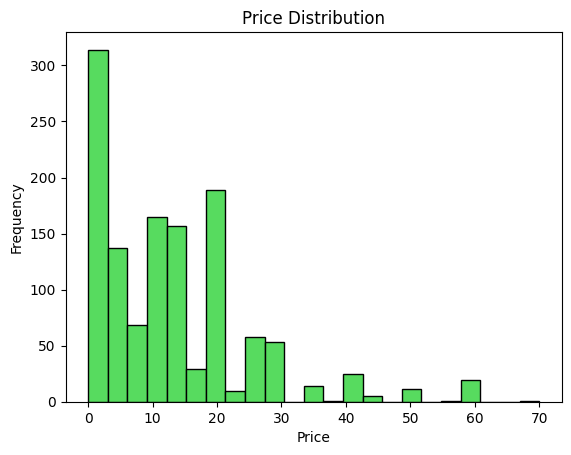

In [173]:
plt.hist(df['PRICE'], bins='auto', color=feature_color_map['PRICE'], edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

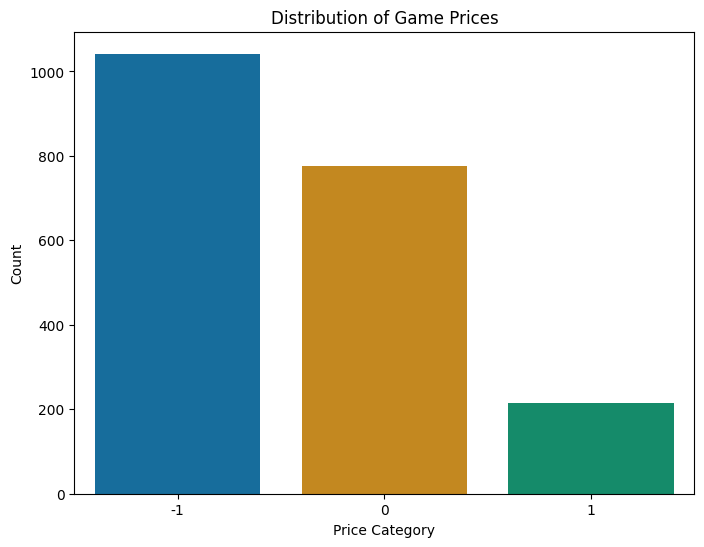

In [174]:
def categorize_price(price):
    if pd.isna(price):
        return 0
    elif price == 0:
        return 1
    else:
        return -1

df = df.assign(PRICE_CATEGORY=df['PRICE'].apply(categorize_price))

price_category_counts = df['PRICE_CATEGORY'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=price_category_counts.index, y=price_category_counts.values, palette='colorblind')

plt.xlabel('Price Category')
plt.ylabel('Count')
plt.title('Distribution of Game Prices')
plt.show()


In [175]:
df['PRICE'].describe()

count    1257.000000
mean       13.113294
std        12.243899
min         0.000000
25%         3.190000
50%         9.990000
75%        19.990000
max        69.990000
Name: PRICE, dtype: float64

##  Summary statistics for the `PUBLISH_YEAR` column

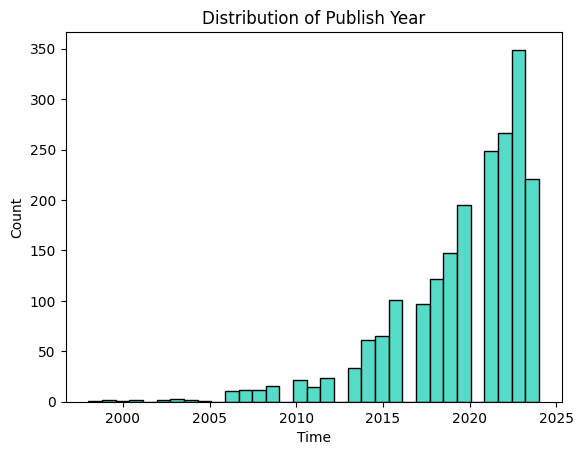

In [176]:
plt.hist(df['PUBLISH_YEAR'], bins='auto', color=feature_color_map['PUBLISH_YEAR'], edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Publish Year')
plt.show()

In [177]:
df['PUBLISH_YEAR'].describe()

count    2032.000000
mean     2019.641240
std         4.081244
min      1998.000000
25%      2018.000000
50%      2021.000000
75%      2023.000000
max      2024.000000
Name: PUBLISH_YEAR, dtype: float64

## Plot the average `24_HOUR_PEAK` for each year (`PUBLISH_YEAR`)

In [178]:
print(sorted(df["PUBLISH_YEAR"].unique()))

[1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


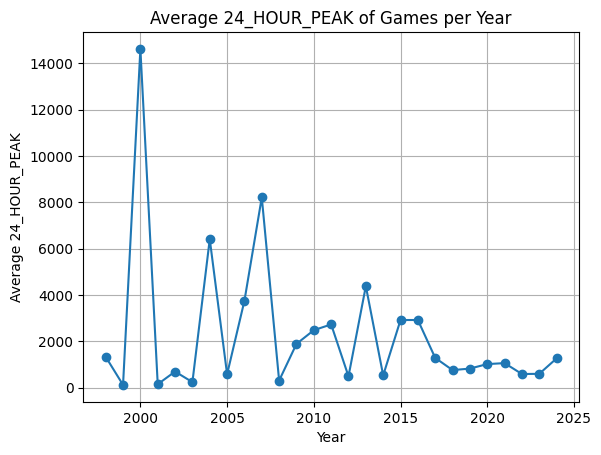

In [179]:
average_peak24_per_year = df.groupby('PUBLISH_YEAR')['24_HOUR_PEAK'].mean()

plt.plot(average_peak24_per_year.index, average_peak24_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Average 24_HOUR_PEAK')
plt.title('Average 24_HOUR_PEAK of Games per Year')
plt.grid(True)
plt.show()

## `Platform` Analysis

OS: Linux 2034.064833005894
OS: Windows 1185.7367125984251
OS: macOS 1597.2536520584329


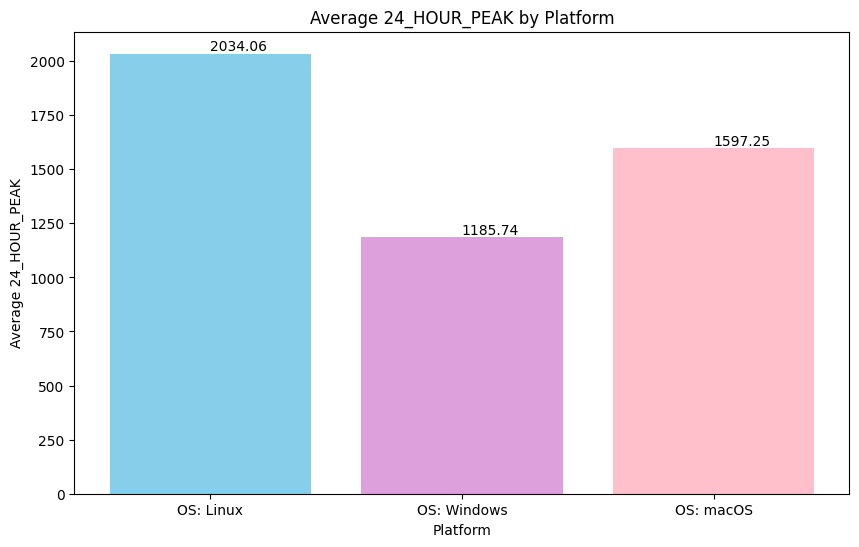

In [180]:
averages = []
for platform in platforms:
    avg = df.loc[df[platform] == 1, '24_HOUR_PEAK'].mean()
    averages.append(avg)
    print(platform, avg)
colors = ['skyblue', 'plum', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.bar(platforms, averages, color=colors)

for bar, avg in zip(bars, averages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(avg, 2), va='bottom')  # va: vertical alignment

plt.title('Average 24_HOUR_PEAK by Platform')
plt.xlabel('Platform')
plt.ylabel('Average 24_HOUR_PEAK')
plt.show()

del averages


In [181]:
df['PLATFORM_COUNT'] = df[platforms].sum(axis=1)
numerical_features.append('PLATFORM_COUNT')

platform_groups = df.groupby('PLATFORM_COUNT').agg({
    '24_HOUR_PEAK': 'mean'
})

platform_groups.reset_index(inplace=True)

platform_groups

,PLATFORM_COUNT,24_HOUR_PEAK
0,1,891.025556
1,2,1114.720745
2,3,2052.975169


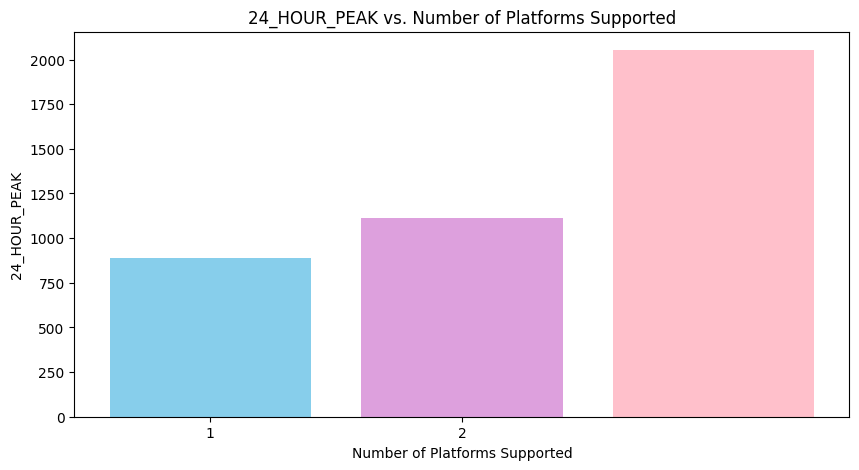

In [182]:
colors = ['skyblue', 'plum', 'pink']
metrics = ['24_HOUR_PEAK']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(platform_groups['PLATFORM_COUNT'], platform_groups[metric], color=colors)
    plt.xlabel('Number of Platforms Supported')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Number of Platforms Supported')
    plt.xticks(range(1, 3))
    plt.show()

##  Relation between `24_HOUR_PEAK` and `STORE_GENRE`

GENRE: Action 1684.2761104441777
GENRE: Adventure 846.6421052631579
GENRE: Casual 497.15686274509807
GENRE: Early Access 1883.779761904762
GENRE: Free to Play 1593.5118110236222
GENRE: Indie 815.6311475409836
GENRE: Massively Multiplayer 5630.611111111111
GENRE: RPG 2044.4896073903003
GENRE: Racing 1816.388888888889
GENRE: Simulation 1857.577731092437
GENRE: Sports 3348.6666666666665
GENRE: Store Genres 110.0
GENRE: Strategy 1770.7415384615385


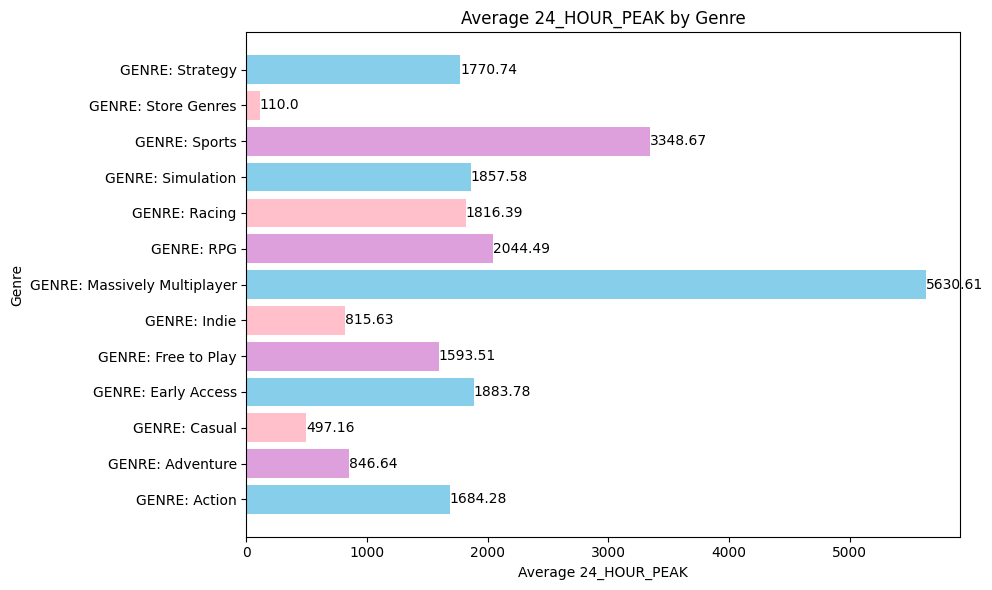

In [183]:

averages = []
for genre in genres:
    avg = df.loc[df[genre] == 1, '24_HOUR_PEAK'].mean()
    averages.append(avg)
    print(genre, avg)

colors = ['skyblue', 'plum', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.barh(genres, averages, color=colors)

for bar, avg in zip(bars, averages):
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height() / 2, round(avg, 2), va='center', ha='left')

plt.title('Average 24_HOUR_PEAK by Genre')
plt.ylabel('Genre')
plt.xlabel('Average 24_HOUR_PEAK')
plt.tight_layout()
plt.show()

In [184]:
df['GENRE_COUNT'] = df[genres].sum(axis=1)
numerical_features.append('GENRE_COUNT')

genres_groups = df.groupby('GENRE_COUNT').agg({
    '24_HOUR_PEAK': 'mean'
})

genres_groups.reset_index(inplace=True)

genres_groups

,GENRE_COUNT,24_HOUR_PEAK
0,1,1361.958944
1,2,1020.815466
2,3,1013.255118
3,4,867.419255
4,5,2796.383929
5,6,1846.976744
6,7,9656.600000
7,8,231.500000
8,9,19.333333


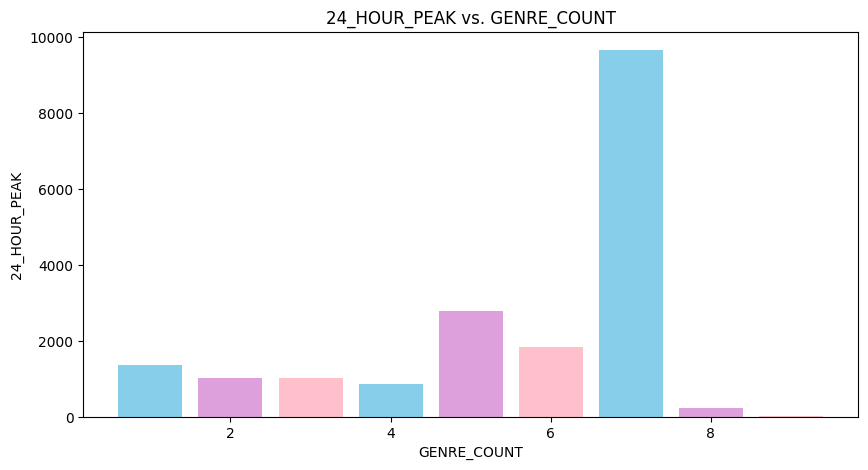

In [185]:
colors = ['skyblue', 'plum', 'pink']
metrics = ['24_HOUR_PEAK']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(genres_groups['GENRE_COUNT'], genres_groups[metric], color=colors)
    plt.xlabel('GENRE_COUNT')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. GENRE_COUNT')
    plt.show()

## Analyze `REVIEWS` metrics

In [186]:
df.head(1)

,NAME,N_SUPPORTED_LANGUAGES,DEVELOPERS,POSITIVE_REVIEWS,NEGATIVE_REVIEWS,PRICE,24_HOUR_PEAK,PUBLISH_YEAR,RATING_SCORE,TOTAL_RATE_SUM,...,GENRE: Simulation,GENRE: Sports,GENRE: Store Genres,GENRE: Strategy,OS: Linux,OS: Windows,OS: macOS,PRICE_CATEGORY,PLATFORM_COUNT,GENRE_COUNT
0,470,7,205,39271,5015,NaN,1064.0,2016,0.886759,44286,...,0,0,0,0,0,1,0,0,1,3


In [187]:
if 'NEGATIVE_REVIEWS_percentage' not in df.columns:
    df['NEGATIVE_REVIEWS_percentage'] = df['NEGATIVE_REVIEWS']/df['TOTAL_RATE_SUM']
    numerical_features.append('NEGATIVE_REVIEWS_percentage')

reviews = ['RATING_SCORE', 'NEGATIVE_REVIEWS_percentage', 'POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'TOTAL_RATE_SUM']


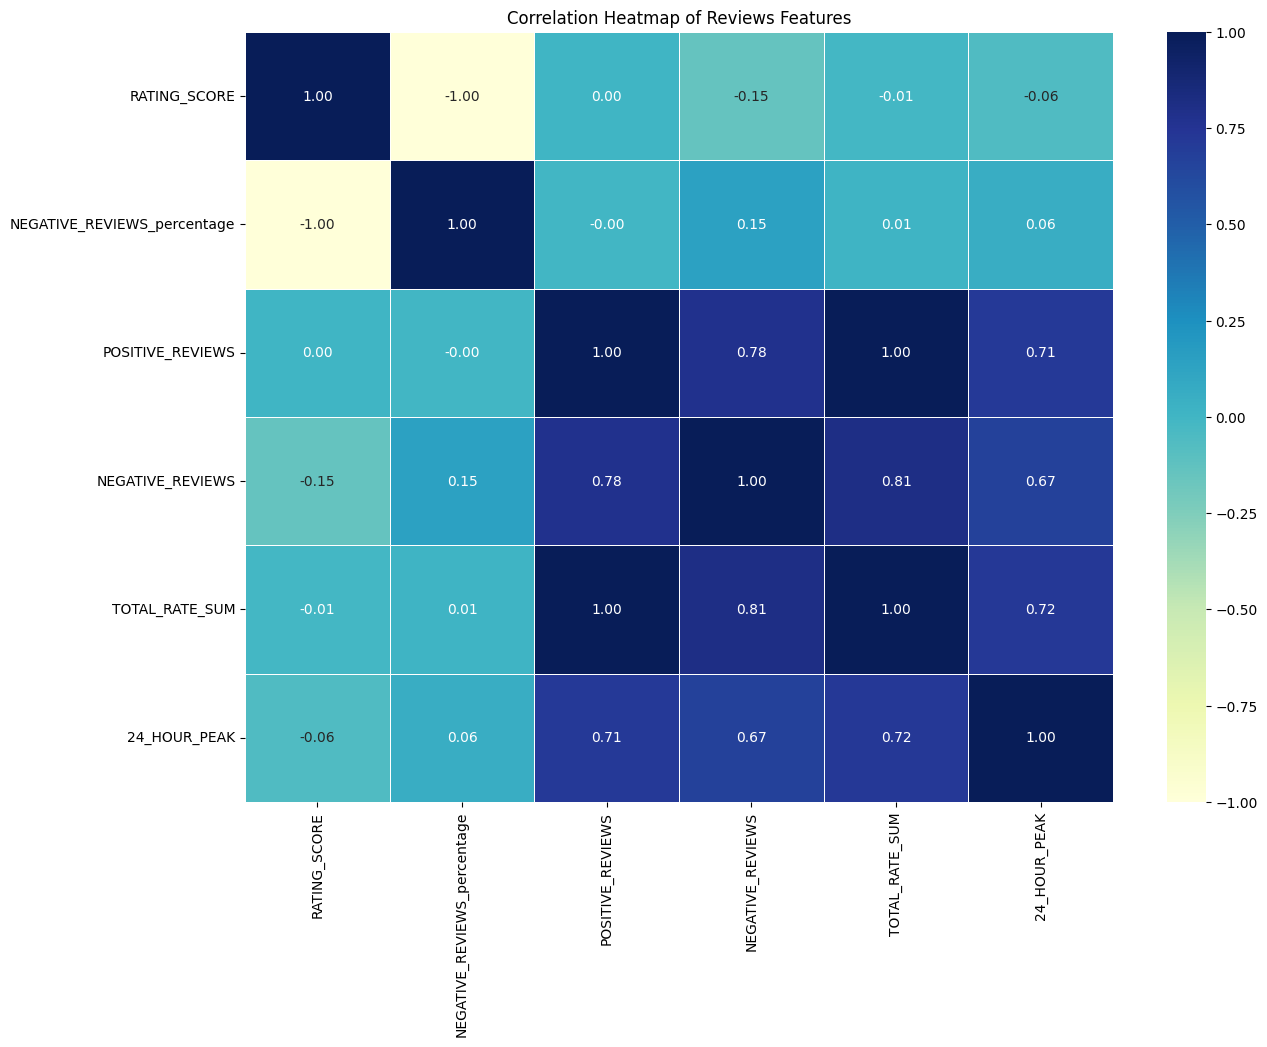

In [188]:
targets = reviews 
targets.append('24_HOUR_PEAK')



correlation_matrix = df[targets].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Reviews Features')
plt.show()

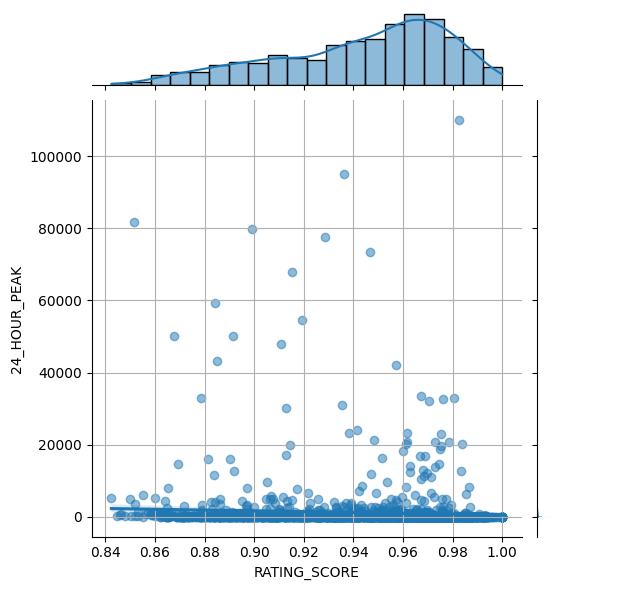

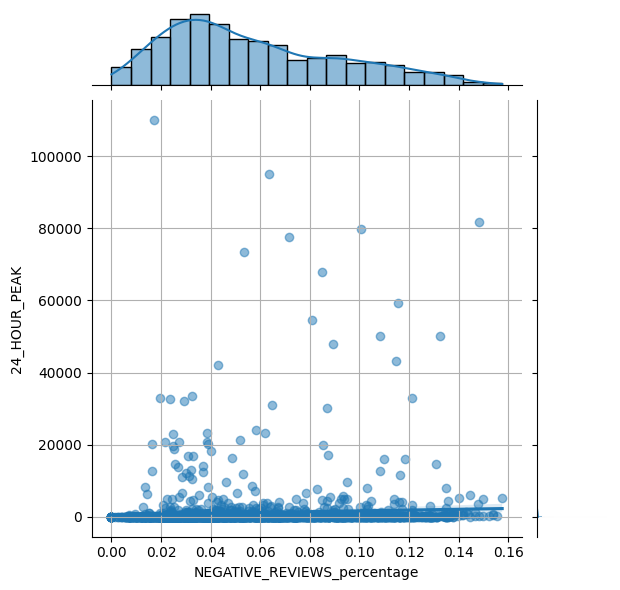

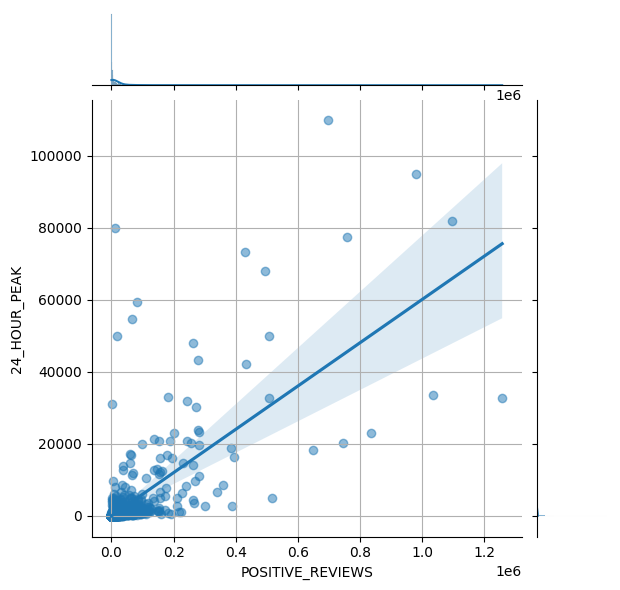

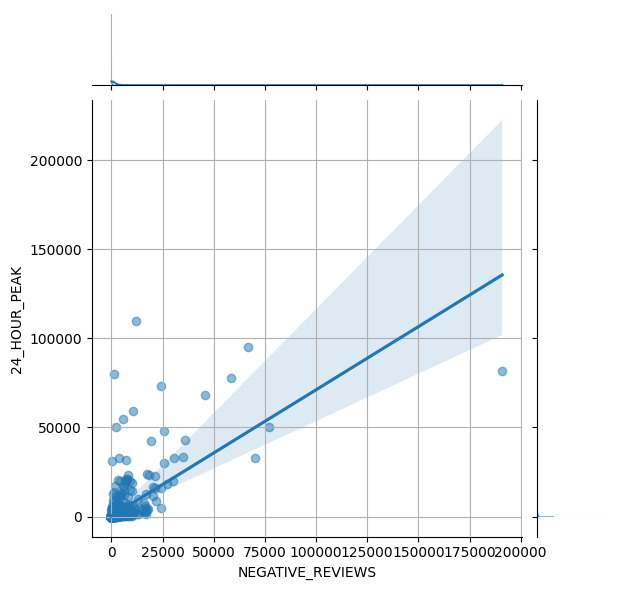

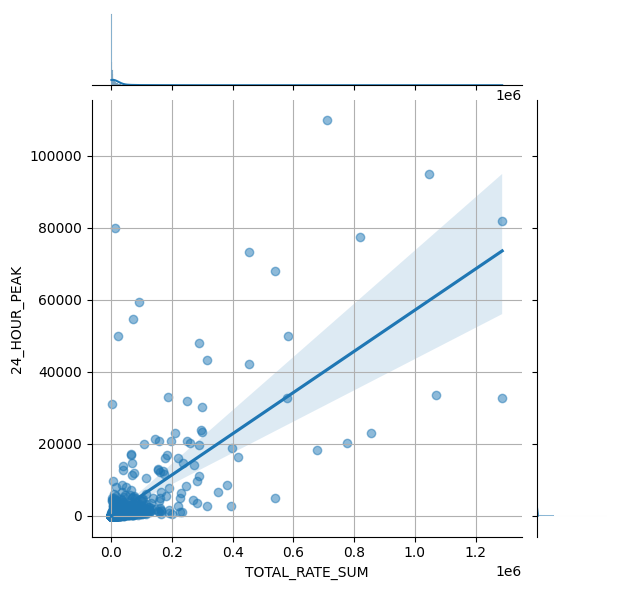

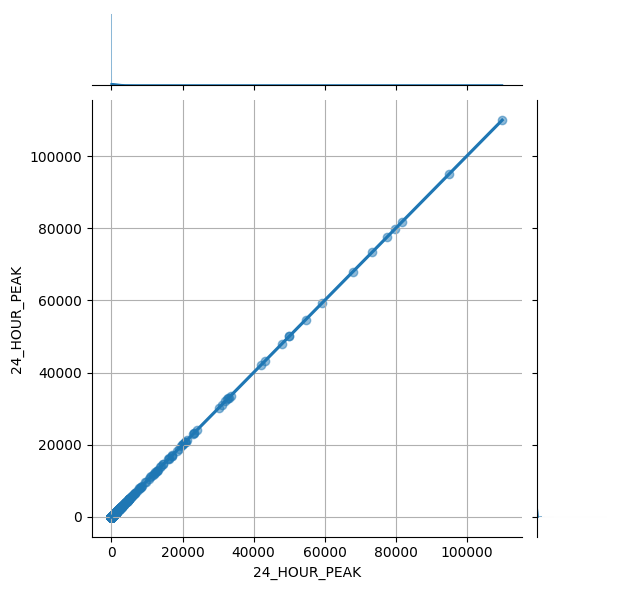

In [189]:
for metric in reviews:
    sb.jointplot(x=metric, y='24_HOUR_PEAK', data=df, kind='reg', scatter_kws={'alpha':0.5})
    plt.xlabel(f'{metric}')
    plt.ylabel('24_HOUR_PEAK')
    plt.grid(True)
    plt.show()
    

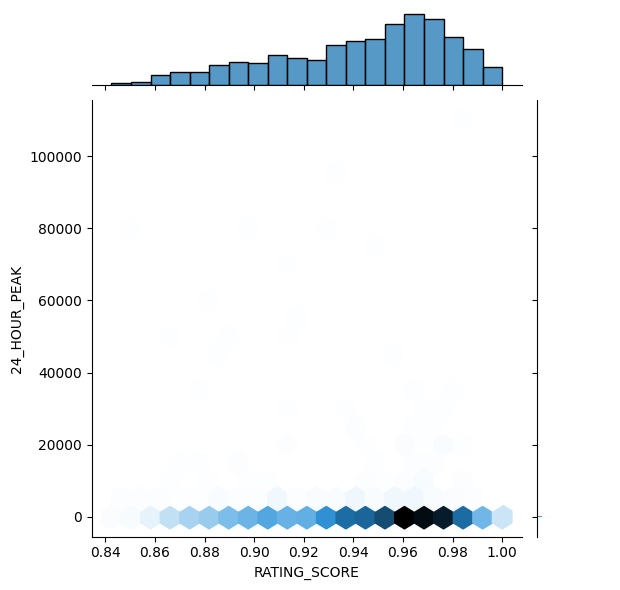

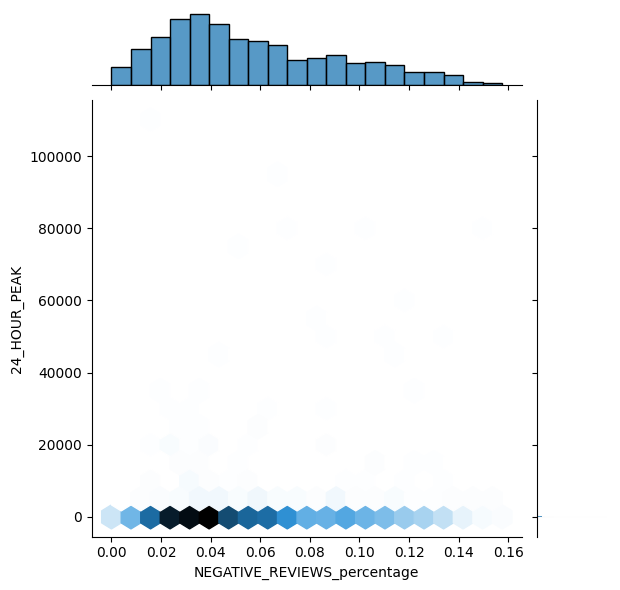

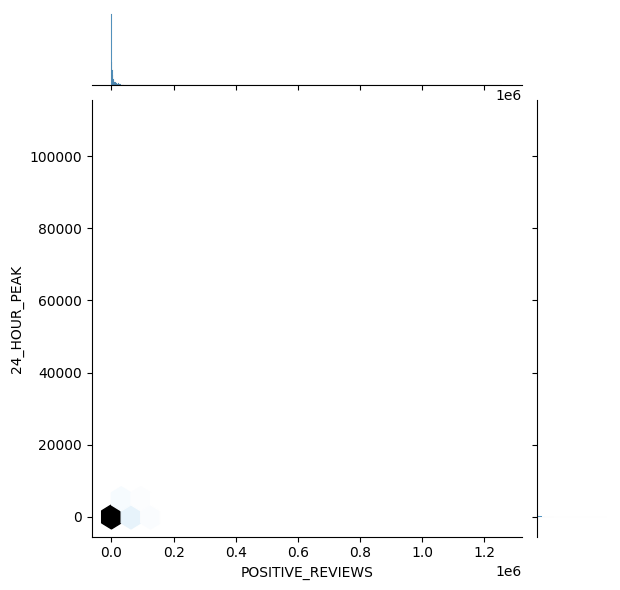

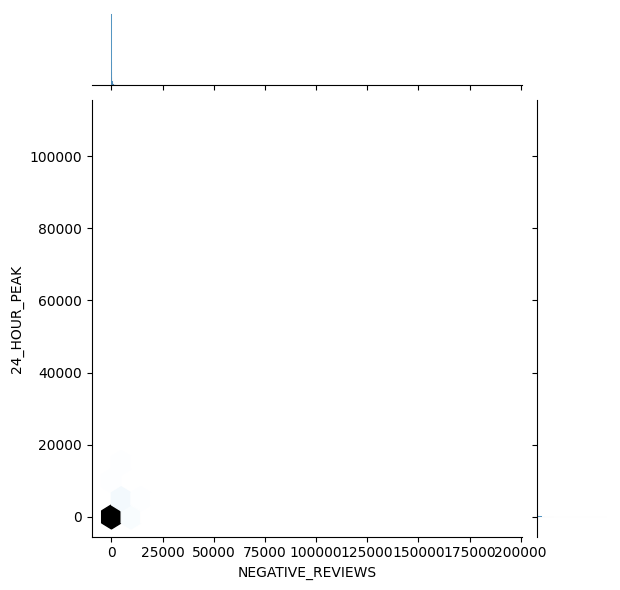

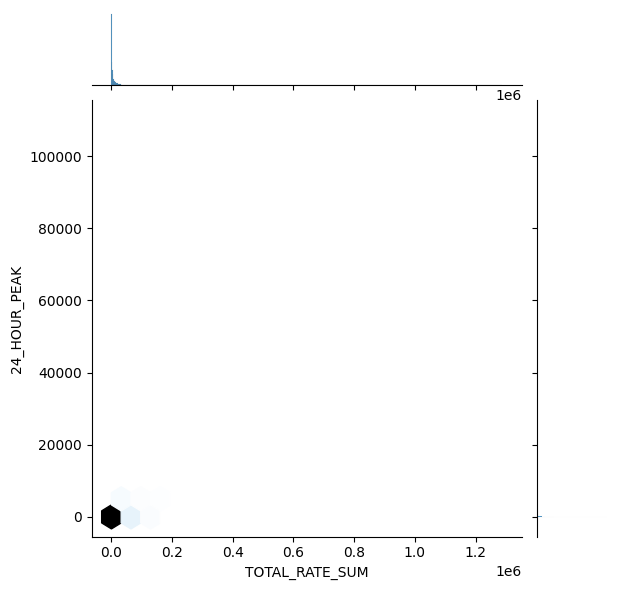

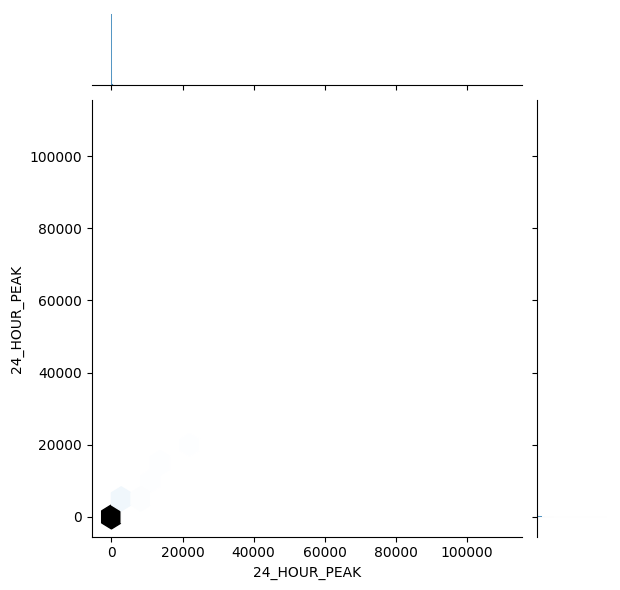

In [190]:
for metric in reviews:
    sb.jointplot(x=metric, y='24_HOUR_PEAK', data=df, kind='hex', gridsize=20)
    plt.xlabel(metric)
    plt.ylabel('24_HOUR_PEAK')
    plt.show()


In [191]:
df.query("RATING_SCORE >= 0.99").sort_values(by="RATING_SCORE", ascending=False)[["NAME", "DEVELOPERS", "RATING_SCORE", "24_HOUR_PEAK"]]

,NAME,DEVELOPERS,RATING_SCORE,24_HOUR_PEAK
26,1792,1080,1.000000,2.0
341,658,1610,1.000000,1.0
1967,505,1121,1.000000,1.0
1929,2009,1387,1.000000,1.0
1092,655,63,1.000000,7.0
...,...,...,...,...
1624,1161,441,0.990215,10.0
1257,793,1527,0.990202,26.0
1022,267,1374,0.990148,7.0
938,377,1429,0.990025,26.0


### Developer Analysis

In [192]:
developer_game_count = df['DEVELOPERS'].value_counts()

developer_24_HOUR_PEAK_summary = df.groupby('DEVELOPERS')['24_HOUR_PEAK'].mean().sort_values(ascending=False)

developer_summary = pd.DataFrame({
    'Game Count': developer_game_count,
    'Average 24_HOUR_PEAK': developer_24_HOUR_PEAK_summary
}).dropna().sort_values(by='Game Count', ascending=False)

developer_summary

,Game Count,Average 24_HOUR_PEAK
DEVELOPERS,,
1420,15,10115.800000
1214,14,422.357143
67,11,2.454545
194,10,1256.800000
1583,7,20.714286
...,...,...
681,1,5.000000
680,1,356.000000
679,1,1898.000000


## Correlation Heatmap

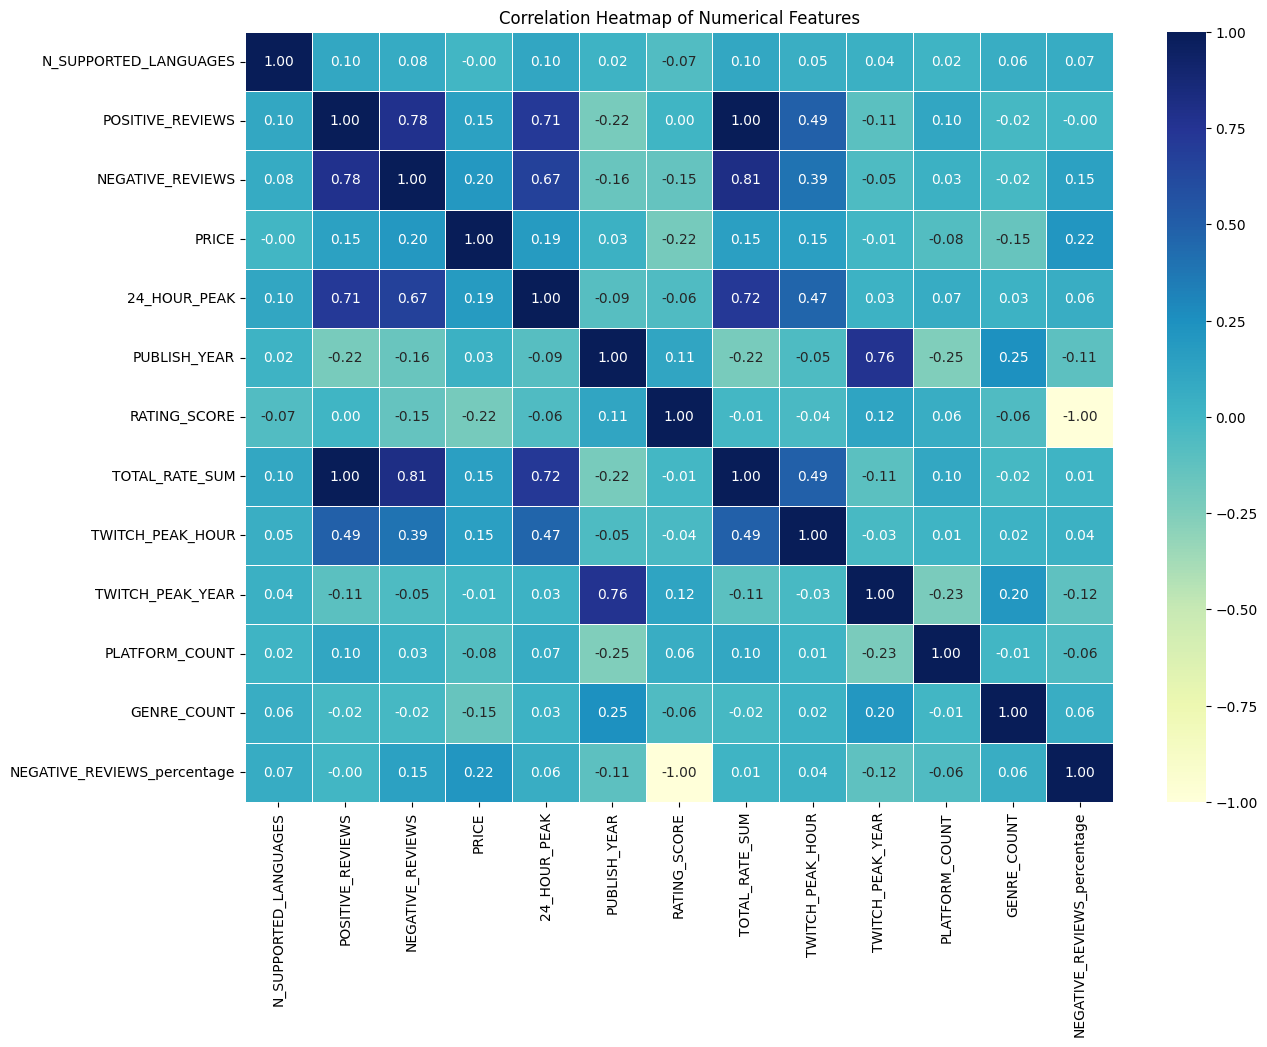

In [193]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

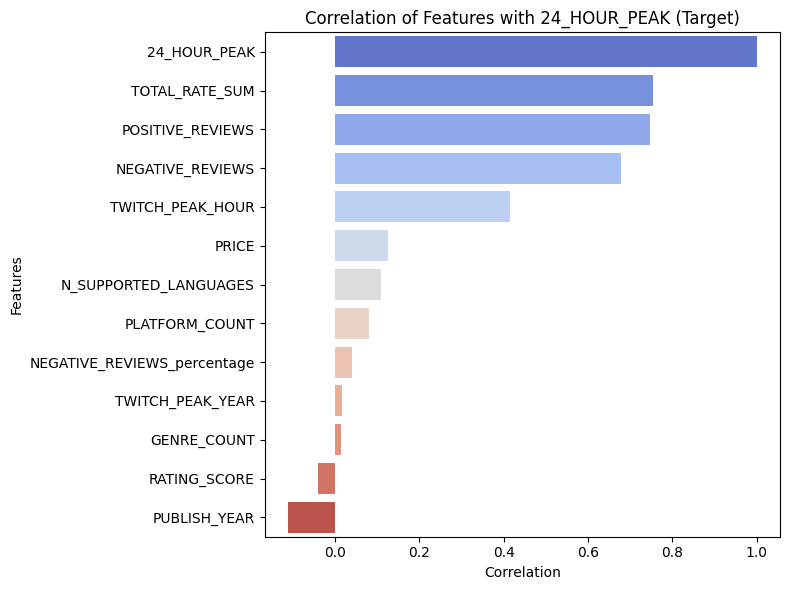

In [194]:
plt.figure(figsize=(8, 6))
sns.barplot(y=target_corr.index, x=target_corr, palette='coolwarm', orient='h')
plt.title('Correlation of Features with 24_HOUR_PEAK (Target)')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## Feature Selection

In [195]:
df = df.drop(columns=technologies)

In [196]:
df = df.drop(columns = "PRICE")

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NAME                          2032 non-null   int32  
 1   N_SUPPORTED_LANGUAGES         2032 non-null   int64  
 2   DEVELOPERS                    2032 non-null   int32  
 3   POSITIVE_REVIEWS              2032 non-null   int64  
 4   NEGATIVE_REVIEWS              2032 non-null   int64  
 5   24_HOUR_PEAK                  2032 non-null   float64
 6   PUBLISH_YEAR                  2032 non-null   int64  
 7   RATING_SCORE                  2032 non-null   float64
 8   TOTAL_RATE_SUM                2032 non-null   int64  
 9   TWITCH_PEAK_HOUR              2032 non-null   float64
 10  TWITCH_PEAK_YEAR              2032 non-null   int64  
 11  GENRE: Action                 2032 non-null   int64  
 12  GENRE: Adventure              2032 non-null   int64  
 13  GEN

In [198]:
# TODO !!!!!!!!!!!

# Dimensionality Reduction

Using the PCA method, reduce the dimensions of numerical features to two dimensions. 


How much of the initial data variance is transferred to the new space?

If we aim to retain 95% of the original variance, what is the minimum number of dimensio s
required in the new space? Save both the original data and the dimension-reduced one  or
the next parts.

In [202]:
# Apply PCA to reduce to 2 dimensions

pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(df)

In [203]:
# Calculate the variance explained by the 2D PCA

variance_explained_2d = pca_2d.explained_variance_ratio_.sum()
variance_explained_2d

0.9974799233770231

In [211]:
# pca_full = PCA().fit(df)
# cumulative_variance_explained = pca_full.explained_variance_ratio_.cumsum()
# n_components_95 = next(i for i, cumulative_variance in enumerate(cumulative_variance_explained) if cumulative_variance >= 0.95) + 1
# pca_95 = PCA(n_components=n_components_95)
# pca_95_result = pca_95.fit_transform(df)

In [212]:
original_data = df
dimension_reduced_data_2d = pd.DataFrame(pca_2d_result, columns=['PC1', 'PC2'])

# Evaluation Metric

Choose appropriate evaluation metrics based on the nature of the data and the project goal, and **explain your reasons for choosing them.**